In [1]:
%matplotlib inline
import cv2 as cv
import numpy as np
from PIL import Image
from matplotlib import style
style.use("ggplot")
import random
import tensorflow as tf
import pandas as pd
import sys

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
graph_path = '/data1/paritosh.pandey/model/frozen_inference_graph.pb'
with tf.gfile.FastGFile(graph_path,'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    print('Detection module loaded...')

Detection module loaded...


In [3]:
image_path = '/data1/paritosh.pandey/CIGDataset/ShelfImages/C1_P11_N1_S3_1.JPG'
img = Image.open(image_path)
ing = np.array(img)
ing = ing[:, :, ::-1].copy()

In [4]:
imgCropTest = ing
ing = cv.resize(ing,(600,600))

In [6]:
with tf.Session() as sess:
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
        sess.graph.get_tensor_by_name('detection_scores:0'),
        sess.graph.get_tensor_by_name('detection_boxes:0'),
        sess.graph.get_tensor_by_name('detection_classes:0')],
       feed_dict={'image_tensor:0': ing.reshape(1, ing.shape[0], ing.shape[1], 3)})
    print("Bounding boxes calculated...")

Bounding boxes calculated...


In [7]:
num_detections = int(out[0][0])
bound_box = out[2][0]

In [11]:
indexS = np.argsort(bound_box[:,3])

In [12]:
indexSR = np.argsort(indexS)
bound_box = bound_box[indexS,:]
printF = True
for i in range(2, bound_box.shape[0]):
    if (bound_box[i-1,0] == 0) & (bound_box[i-1,1] == 0) & (bound_box[i-1,2] == 0) & (bound_box[i-1,3] == 0):
        continue
    if printF: 
        print(i)
        printF = False
    area1 = 1000000*(bound_box[i,3]-bound_box[i,1])*(bound_box[i,2]-bound_box[i,0])
    area2 = 1000000*(bound_box[i-1,3]-bound_box[i-1,1])*(bound_box[i-1,2]-bound_box[i-1,0])
    overlap_area = 1000000*(np.minimum(bound_box[i,3], bound_box[i-1,3])-np.maximum(bound_box[i,1], bound_box[i-1,1]))*(np.minimum(bound_box[i,2], bound_box[i-1,2])-np.maximum(bound_box[i,0], bound_box[i-1,0]))

    if overlap_area >= 0.8*np.minimum(area2,area1):
        if area2 < area1:
            bound_box[i,:] = 0
            print('Area2 ' + str(i))
        else:
            bound_box[i-1,:] = 0
            print('Area1 ' + str(i))
                    
bound_box = bound_box[indexSR,:]

73


In [13]:
out[2][0] = bound_box

In [15]:
Y = np.zeros([num_detections,2])
Y = bound_box[0:num_detections,:]
trial = Y[:,0]
ind = np.argsort(trial)
trial = np.sort(trial)
diff = trial[1:]-trial[:-1]
diff2 = diff[1:]-diff[:-1]

labInd = np.zeros(len(trial))
for i in range(len(diff)):
    if diff[i] > np.max(diff)*0.3:
        labInd[i+1] = labInd[i]+1
    else:
        labInd[i+1] = labInd[i]

col = [(255,0,0),(0,255,0),(0,0,255)]
for i in range(3,len(np.unique(cluster_info))):
    col.append((255,random.randint(0,256),random.randint(0,256)))    
print('Rack information calculated...')

NameError: name 'cluster_info' is not defined

array([2, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 0, 2, 2,
       0, 0, 1, 1, 2, 2, 2, 2, 1], dtype=int32)

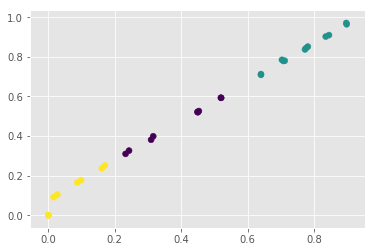

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
cluster_info = KMeans(n_clusters = 3).fit_predict(Y[:,[1,3]])
plt.scatter(Y[:, 1], Y[:, 3], c=cluster_info)      
cluster_info

Rack information calculated...


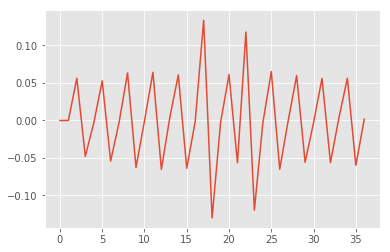

In [62]:
X = np.zeros([num_detections,2])
X = bound_box[0:num_detections,:]
trial = (X[:,1] + X[:,3])/2
ind = np.argsort(trial)
trial = np.sort(trial)
diff = trial[1:]-trial[:-1]
diff2 = diff[1:]-diff[:-1]

import matplotlib.pyplot as py

py.plot(diff2)
labInd = np.zeros(len(trial))
for i in range(len(diff)):
    if diff[i] > np.max(diff)*0.8:
        labInd[i+1] = labInd[i]+1
    else:
        labInd[i+1] = labInd[i]

col = [(255,0,0),(0,255,0),(0,0,255)]
for i in range(3,len(np.unique(labInd))):
    col.append((255,random.randint(0,256),random.randint(0,256)))    
print('Rack information calculated...')

In [63]:
index = np.where(labInd == 1)
bbox = bound_box[ind[index],:]
bbox = np.sort(bbox, axis = 0)
np.unique(bbox[:,0])

array([0.14084814, 0.43984896, 0.4477359 , 0.7303144 , 0.73524266],
      dtype=float32)

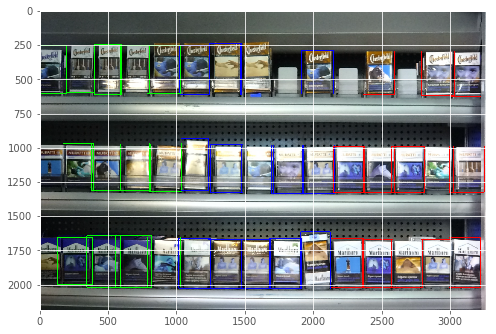

In [25]:
import matplotlib.pyplot as plt
rowsCT = imgCropTest.shape[0]
colsCT = imgCropTest.shape[1]
ing = cv.resize(ing, (colsCT,rowsCT))

for i in range(num_detections):
    index = np.where(ind == i)
    score = float(out[1][0][i])
    bbox = [float(v) for v in out[2][0][i]]
    if (bbox[0] == 0) & (bbox[1] == 0) & (bbox[2] == 0) & (bbox[3] == 0):
        continue 
    if score > 0.3:
        x = bbox[1] * colsCT
        y = bbox[0] * rowsCT
        right = bbox[3] * colsCT
        bottom = bbox[2] * rowsCT
        cv.rectangle(ing, (int(x), int(y)), (int(right), int(bottom)), col[int(cluster_info[i])], thickness=4)
plt.figure(figsize=(8, 6))
plt.imshow(ing)
plt.show()

In [15]:
from keras.models import model_from_json
model_json = "/data1/paritosh.pandey/model_30_32_cropped.json"
arch_file_json = open(model_json,'r')
model_json = arch_file_json.read()
arch_file_json.close()
loaded_model = model_from_json(model_json)
loaded_model.load_weights("/data1/paritosh.pandey/weights_30_32_cropped.h5")
print('Classifier loaded...')

Using TensorFlow backend.


Classifier loaded...


In [16]:
rowsCT = imgCropTest.shape[0]
colsCT = imgCropTest.shape[1]
x_max = np.amax(bound_box[:,3])
x_min = np.amin(bound_box[bound_box[:,1] > 0,1])

shelfRatios = np.zeros((len(np.unique(labInd)),17))
shelfCoverage = np.zeros((len(np.unique(labInd)),17))
length = np.zeros((len(np.unique(labInd)),1))
infoList = []
size = np.ones((17,1))
print('Starting classification module...')
for i in range(len(np.unique(labInd))):
    index = np.where(labInd == i)
    bbox = bound_box[ind[index],:]
    if len(np.unique(bbox[:,0])) == 1:
        continue
    infoList.append(i)
    bbox = np.sort(bbox, axis = 0)
    if 0 in np.unique(bbox):
        locs = np.unique(np.where(bbox == 0)[0])
        if len(np.unique(bbox[locs,:])) == 1:
            bbox = bbox[np.unique(np.where(bbox != 0)[0]),:]
        else:
            for loc in locs:
                if len(np.where(bbox[loc, :] == 0)[0]) == 4:
                    bbox[loc,:] = np.nan
            bbox = bbox[~np.any(np.isnan(bbox), axis=1)]
            
    maxX = 0
    minX = np.amin(bbox[:,1])
    images = np.zeros((bbox.shape[0],224,224,3)) 
    for j in range(bbox.shape[0]):
        testImg = imgCropTest[int(rowsCT*bbox[j,0]):int(rowsCT*bbox[j,2])+1,int(colsCT*bbox[j,1]):int(colsCT*bbox[j,3])+1]
        testImgR = cv.resize(testImg,(224,224))
        images[j,:,:,:] = testImgR
    pred_label = loaded_model.predict(images/255)
    #print(np.max(pred_label,1),np.argmax(pred_label,1))
    for j in range(bbox.shape[0]):
        shelfRatios[i,np.argmax(pred_label[j,:])] += 1
        shelfCoverage[i,np.argmax(pred_label[j,:])] += bbox[j,3]-np.maximum(bbox[j,1],maxX)
        maxX = bbox[j,3]
        size[np.argmax(pred_label[j,:])] = np.minimum(size[np.argmax(pred_label[j,:])],bbox[j,3]-bbox[j,1])
    length[i] = 0.12*(x_max - x_min) + 0.88*(maxX - minX)
print('Shelf coverage calculated...')

Starting classification module...
Shelf coverage calculated...


In [17]:
print(shelfRatios)
print(shelfCoverage)
print(length)

[[0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 2. 1.]]
[[0.         0.54543555 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.52640763 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.5475322  0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.53526631 0.
  0.         0.         0.         0.         0.        ]
 [0.         0.  

In [18]:
shelfRatios = shelfRatios[infoList,:]

In [19]:
shlfDf = pd.DataFrame(np.transpose(shelfRatios))
shlfDf.set_index([[chr(i) for i in range(ord('A'),ord('A')+17)]],inplace=True)
shlfDf.columns = ['Rack '+ str(i+1) for i in range(shlfDf.shape[1])]
shlfDf['Total'] = shlfDf.sum(axis=1)
shlfDf.Total.replace(0,np.nan,inplace=True)
shlfDf.dropna(subset=['Total'],axis=0,inplace=True)
shlfDf['Number of Products (%)'] = 100*shlfDf.Total/shlfDf.Total.sum()

In [20]:
shelfCoverage = shelfCoverage[infoList,:]

In [21]:
length = length[infoList,:]

In [22]:
df = pd.DataFrame(shelfCoverage)
df.columns = [chr(i) for i in range(ord('A'),ord('A')+17)]
df['Length Of Rack'] = length
df = df.T
df.columns = ['Rack ' + str(i+1) for i in range(df.shape[1])]
df['Occupied Product Area (%)'] = df.sum(axis=1)
df['Occupied Product Area (%)'].replace(0,np.nan,inplace=True)
df.dropna(subset=['Occupied Product Area (%)'],axis=0,inplace=True)
df

,Rack 1,Rack 2,Rack 3,Rack 4,Rack 5,Occupied Product Area (%)
B,0.545436,0.000000,0.000000,0.000000,0.000000,0.545436
D,0.000000,0.526408,0.000000,0.000000,0.109011,0.635419
J,0.000000,0.000000,0.547532,0.000000,0.000000,0.547532
K,0.000000,0.000000,0.000000,0.535266,0.000000,0.535266
L,0.000000,0.000000,0.000000,0.000000,0.121107,0.121107
P,0.000000,0.000000,0.000000,0.000000,0.223306,0.223306
Q,0.000000,0.000000,0.000000,0.000000,0.112921,0.112921
Length Of Rack,0.626034,0.622105,0.621475,0.619479,0.630518,3.119612


In [23]:
resultDf = 100*df/df.iloc[df.shape[0]-1]
resultDf = resultDf.iloc[[i for i in range(resultDf.shape[0]-1)]]

In [24]:
print(df.iloc[df.shape[0]-1])
print(resultDf)

Rack 1                       0.626034
Rack 2                       0.622105
Rack 3                       0.621475
Rack 4                       0.619479
Rack 5                       0.630518
Occupied Product Area (%)    3.119612
Name: Length Of Rack, dtype: float64
      Rack 1     Rack 2     Rack 3     Rack 4     Rack 5  \
B  87.125577   0.000000   0.000000   0.000000   0.000000   
D   0.000000  84.617125   0.000000   0.000000  17.289113   
J   0.000000   0.000000  88.102017   0.000000   0.000000   
K   0.000000   0.000000   0.000000  86.405873   0.000000   
L   0.000000   0.000000   0.000000   0.000000  19.207466   
P   0.000000   0.000000   0.000000   0.000000  35.416325   
Q   0.000000   0.000000   0.000000   0.000000  17.909267   

   Occupied Product Area (%)  
B                  17.484084  
D                  20.368517  
J                  17.551292  
K                  17.158106  
L                   3.882106  
P                   7.158149  
Q                   3.619721  


In [25]:
print(size)
size = size[size!=1]
print(size)

[[1.        ]
 [0.09687722]
 [1.        ]
 [0.1021176 ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.10374868]
 [0.10105759]
 [0.12110662]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.1092456 ]
 [0.11292124]]
[0.09687722 0.1021176  0.10374868 0.10105759 0.12110662 0.1092456
 0.11292124]


In [26]:
vacancy = np.zeros((resultDf.shape[0], resultDf.shape[1]-1))
for i in range(df.shape[1]-1):
    st = 'Rack ' + str(i+1)
    lengthOfRacks = df.iloc[df.shape[0]-1]
    if resultDf[st].sum() < 99.9:
        space = (100 - resultDf[st].sum())*lengthOfRacks[st]/100
        print(space)
        vacancy[:,i] = space/size
vacancy[(vacancy < 1) & (vacancy > 0.95)] = 1
vacancy = np.floor(vacancy)

0.08059823513031006
0.09569768309593195
0.07394301891326902
0.08421277403831481
0.06417309045791632


In [27]:
vacDf = pd.DataFrame(vacancy)
vacDf.set_index(shlfDf.index,inplace=True)
vacDf.columns = ['Rack ' + str(i+1) for i in range(df.shape[1]-1)]
vacDf

,Rack 1,Rack 2,Rack 3,Rack 4,Rack 5
B,0.0,1.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0
J,0.0,0.0,0.0,0.0,0.0
K,0.0,0.0,0.0,0.0,0.0
L,0.0,0.0,0.0,0.0,0.0
P,0.0,0.0,0.0,0.0,0.0
Q,0.0,0.0,0.0,0.0,0.0


In [26]:
p = pd.DataFrame([],["Left","Middle","Right"],[])

In [27]:
p

""
Left
Middle
Right
